# **Example 6.3.2 (Time-series forecast using encoder only transformer architecture)**

## Introduction

This is the Transformer architecture from
[Attention Is All You Need](https://arxiv.org/abs/1706.03762),
applied to timeseries instead of natural language.

This example requires TensorFlow 2.4 or higher.

In [ ]:
import pandas as pd
import tensorflow as tf
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
seed=10
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Parameters of the experiment

train_data_size=25000
test_data_size=2500
data_size=train_data_size+test_data_size
num_epochs = 1000
learning_rate = 0.001
sigma=0.03 # Noise standard deviation
window_length = 30   #Length of the RNN window

input_size = window_length
hidden_size = 100
num_layers = 1
num_classes = 1

###**Defining the input to the model**###

The RNN in the example is built to perform one step-ahead prediction of a time series that consists of a harmonic signal with the expression

\begin{equation}
    x[t] = \cos\left[\frac{\pi}{6} t\right]  + \frac{1}{2}\cos\left[\frac{\pi}{3} t\right] + \frac{1}{2}\cos\left[\frac{2\pi}{3} t\right] + g[t]
\end{equation}
for $0 \leq t \leq 200$, and where $g[n]$ is an additive Gaussian noise of independent and identically distributed samples with standard deviation $\sigma=0.1$.

In [ ]:
from scipy.signal import butter,filtfilt

def data(type,N):
  if type=='harmonics':
    t = np.pi*np.linspace(0,data_size-1,data_size)/6
    y_ = np.cos(t) + np.cos(2*t)/2 + np.cos(4*t)/4
  elif type == 'low_pass':
    u = np.random.randn(data_size)
    b, a = butter(4, 0.1, btype='low', analog=False)
    y_ = np.copy(filtfilt(b, a, u))
  y = y_ + sigma*np.random.randn(data_size)
  return y, y_

#y = data('harmonics',data_size)
y, y_ = data('low_pass',data_size)

##**Visualizing the data**##

Now lets visualize the function and plot the input data.

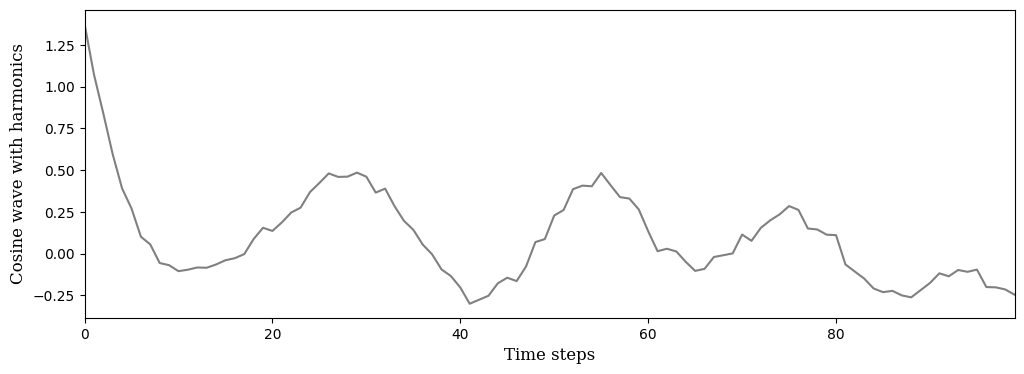

In [ ]:
plt.figure(figsize=(12,4))
csfont = {'fontname':'serif'}
plt.xlim(-1,201)
plt.plot(y[0:100],'Grey')
plt.xlabel('Time steps',fontsize=12,**csfont)
plt.ylabel('Cosine wave with harmonics',fontsize=12,**csfont)
plt.autoscale(axis='x',tight=True)
plt.show()



##**Define Data Processing class**##

Let us define the data preprocessing block for processing the input data.

Using the class first the data is divided into training and test. The data is divided into 150 samples for training and 50 for testing. Following this feature normalization is performed using the MinMaxScaler() function and the data is scaled between 0 and 1. All these operations are performed using the *get_train_test()* method.

Next, we define the sliding window for scanning the training and test data. We split the training sequence into overlapping windows. For example, if we have a sequence with 16 samples and a window size of 4, we can enter [x1, x2, x3, x4] into the model and compare the forecast to x5. Next we input [x2, x3, x4, x5] into the model and match the forecast to x6 and the process goes on. The sliding window is defined using a function that inputs the data and the sequence length. The output of the function returns the sequence and the corresponding labels. The method *XY_split_sequence()* will return the windowed data and the label.


In [ ]:
class Data_processing():

  def __init__(self, data, test_data_size):
    self.test_dsize = test_data_size
    self.data = data

  def get_train_test(self):
      scaler = MinMaxScaler(feature_range = (0, 1))

      train_data = self.data[:-self.test_dsize]
      test_data = self.data[-self.test_dsize:]
      train_data=train_data.reshape(-1, 1)
      test_data=test_data.reshape(-1, 1)
      self.train_data = scaler.fit_transform(train_data)
      self.test_data = scaler.fit_transform(test_data)
      return self.train_data, self.test_data, scaler

  def XY_split_sequence(self,seq,ws):
      win = []
      lab = []
      L = len(seq)

      for i in range(L-ws):
        window = seq[i:i+ws,]
        label = seq[i+ws:i+ws+1]
        win.append(window)
        lab.append(label)

      return np.array(win), np.array(lab)

In [ ]:
data1=y
data_module = Data_processing(data1, 50)

In [ ]:
train, test, sc = data_module.get_train_test()
trainX, trainY = data_module.XY_split_sequence(train,input_size)
testX, testY = data_module.XY_split_sequence(test,input_size)

In [ ]:
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(27420, 30, 1) (27420, 1, 1) (20, 30, 1) (20, 1, 1)


# Transformer architecture




## Build the model

The model processes a tensor of shape `(batch size, sequence length, features)`,
where `sequence length` is the number of time steps and `features` is each input
timeseries.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

class Transformer_enc_model():
  def __init__(self, input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0, future = 1, activation = 'tanh'):

    self.input_shape = input_shape
    self.head_size = head_size
    self.num_heads = num_heads
    self.ff_dim = ff_dim
    self.num_transformer_blocks = num_transformer_blocks
    self.mlp_units = mlp_units
    self.dropout = dropout
    self.mlp_dropout= mlp_dropout
    self.future = future
    self.activation = activation

  def transformer_encoder(self, inputs):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=self.head_size, num_heads=self.num_heads, dropout=self.dropout
    )(x, x)
    x = layers.Dropout(self.dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=self.ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(self.dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

  def build_transformer_model(self):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(self.num_transformer_blocks):
        x = self.transformer_encoder(x)#, self.head_size, self.num_heads, self.ff_dim, self.dropout)
    x = layers.Flatten()(x)
    x = layers.RepeatVector(1)(x)
    #x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in self.mlp_units:
        #x = layers.LSTM(dim, activation='tanh', return_sequences=True)(x)
        x = layers.Dropout(self.mlp_dropout)(x)
    #outputs = layers.Dense(n_classes, activation="softmax")(x)
    outputs = layers.LSTM(self.future, activation=self.activation, return_sequences=False)(x)
    return keras.Model(inputs, outputs)

  def model_training(self, epochs, batch_size, trainX, trainY, model):
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)
    return model, history

In [ ]:
from sklearn import metrics
input_shape = trainX.shape[1:]
model1 = Transformer_enc_model(
    input_shape,
    head_size=256,
    num_heads=2,
    ff_dim=8,
    num_transformer_blocks=4,
    mlp_units=[206,50],
    mlp_dropout=0.4,
    dropout=0.25,
)

transformer_model = model1.build_transformer_model()

In [ ]:
from keras.optimizers import Adam
opt = Adam(learning_rate=learning_rate)


 # Specify the training configuration.
transformer_model.compile(optimizer=opt,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])

transformer_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30, 1)]              0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 30, 1)                2         ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 30, 1)                3585      ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0][0]'] 
                                                                                              

In [ ]:
transformer_model, history = model1.model_training(epochs=100,batch_size=64,trainX = trainX, trainY = trainY, model = transformer_model)

Epoch 1/100
429/429 [==============================] - 33s 19ms/step - loss: 0.0761 - mse: 0.0761
Epoch 2/100
429/429 [==============================] - 8s 18ms/step - loss: 0.0211 - mse: 0.0211
Epoch 3/100
429/429 [==============================] - 8s 18ms/step - loss: 0.0158 - mse: 0.0158
Epoch 4/100
429/429 [==============================] - 8s 19ms/step - loss: 0.0138 - mse: 0.0138
Epoch 5/100
429/429 [==============================] - 7s 17ms/step - loss: 0.0126 - mse: 0.0126
Epoch 6/100
429/429 [==============================] - 8s 19ms/step - loss: 0.0116 - mse: 0.0116
Epoch 7/100
429/429 [==============================] - 7s 17ms/step - loss: 0.0109 - mse: 0.0109
Epoch 8/100
429/429 [==============================] - 9s 21ms/step - loss: 0.0103 - mse: 0.0103
Epoch 9/100
429/429 [==============================] - 11s 25ms/step - loss: 0.0099 - mse: 0.0099
Epoch 10/100
429/429 [==============================] - 7s 17ms/step - loss: 0.0094 - mse: 0.0094
Epoch 11/100
429/429 [=====

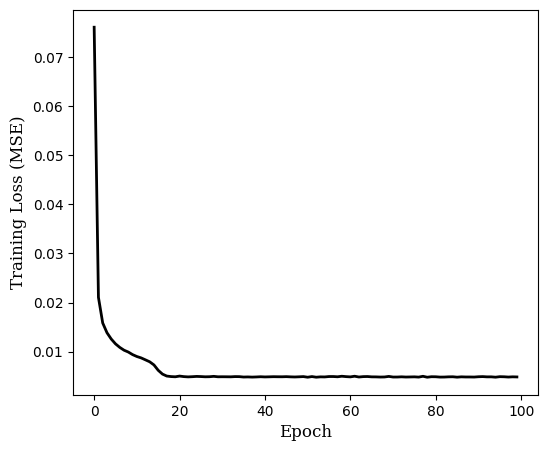

In [ ]:
plt.figure(figsize=(6,5))
csfont = {'fontname':'serif'}
plt.plot(history.history['loss'], lw=2,color='k')
plt.xlabel("Epoch",fontsize=12,**csfont)
plt.ylabel("Training Loss (MSE)",fontsize=12,**csfont)
plt.savefig('transf_ex_loss.pdf')
plt.show()

In [ ]:
data_predict = transformer_model.predict(testX)

1/1 [==============================] - 1s 738ms/step


In [ ]:
data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(testY.reshape(-1,1))

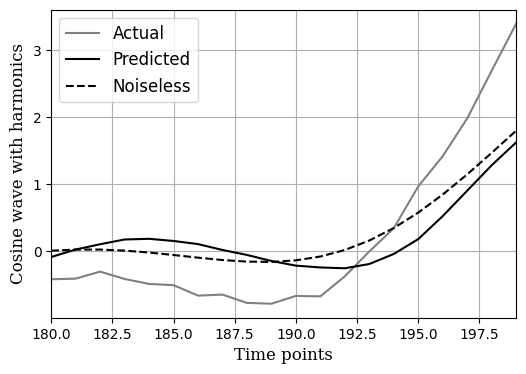

In [ ]:
data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)
plt.figure(figsize=(6,4))
x = np.arange(200-dataY_plot.size,200, 1)
csfont = {'fontname':'serif'}
plt.plot(x,dataY_plot,color='Grey',label='Actual')
plt.plot(x,data_predict,color='Black',label='Predicted')
plt.plot(x, y_[-data_predict.shape[0]:], color='Black',linestyle='dashed',label='Noiseless')
plt.xlabel('Time points',fontsize=12,**csfont)
plt.ylabel('Cosine wave with harmonics',fontsize=12,**csfont)
plt.autoscale(axis='x',tight=True)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('trans_ex_pred.pdf')
plt.show()


Let us try using this model for the flights dataset from previous chapter LSTM problem

In [ ]:
import seaborn as sns
data = sns.load_dataset("flights")
print(data.shape)
data.head()


(144, 3)


,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


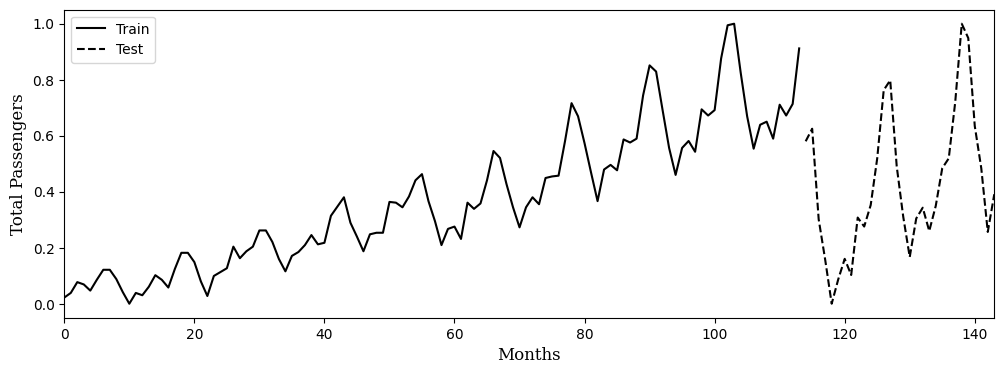

In [ ]:
data1=data['passengers'].values.astype(float)
data_module = Data_processing(data1, 30)

plt.figure(figsize=(12,4))
plt.xlabel('Months',fontsize=12,**csfont)
plt.ylabel('Total Passengers',fontsize=12,**csfont)
plt.autoscale(axis='x',tight=True)
X=data_module.get_train_test()
plt.plot(range(X[0].shape[0]),X[0],color='BLACK',label='Train')
r=range(X[0].shape[0],X[0].shape[0]+X[1].shape[0])


plt.plot(r,X[1],color='BLACK',linestyle='--',label='Test')
plt.legend()
#plt.grid(True)
plt.show()

In [ ]:
train, test, sc = data_module.get_train_test()
window_size=4 #Changed from 12 to 6
trainX, trainY = data_module.XY_split_sequence(train,window_size)
testX, testY = data_module.XY_split_sequence(test,window_size)

In [ ]:
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(110, 4, 1) (110, 1, 1) (26, 4, 1) (26, 1, 1)


In [ ]:
input_shape = trainX.shape[1:]
model1 = Transformer_enc_model(
    input_shape,
    head_size=256,
    num_heads=2,
    ff_dim=8,
    num_transformer_blocks=2,
    mlp_units=[206],
    mlp_dropout=0.4,
    dropout=0.1,
    activation = 'sigmoid'
)

transformer_model = model1.build_transformer_model()

In [ ]:
from keras.optimizers import Adam
opt = Adam(learning_rate=learning_rate)


 # Specify the training configuration.
transformer_model.compile(optimizer=opt,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])

transformer_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 4, 1)]               0         []                            
                                                                                                  
 layer_normalization_8 (Lay  (None, 4, 1)                 2         ['input_2[0][0]']             
 erNormalization)                                                                                 
                                                                                                  
 multi_head_attention_4 (Mu  (None, 4, 1)                 3585      ['layer_normalization_8[0][0]'
 ltiHeadAttention)                                                  , 'layer_normalization_8[0][0]
                                                                    ']                      

In [ ]:
num_epochs = 500
transformer_model, history = model1.model_training(epochs=num_epochs,batch_size=16,trainX = trainX, trainY = trainY, model = transformer_model)

Epoch 1/500
7/7 [==============================] - 8s 39ms/step - loss: 0.0404 - mse: 0.0404
Epoch 2/500
7/7 [==============================] - 0s 22ms/step - loss: 0.0401 - mse: 0.0401
Epoch 3/500
7/7 [==============================] - 0s 20ms/step - loss: 0.0408 - mse: 0.0408
Epoch 4/500
7/7 [==============================] - 0s 19ms/step - loss: 0.0377 - mse: 0.0377
Epoch 5/500
7/7 [==============================] - 0s 20ms/step - loss: 0.0387 - mse: 0.0387
Epoch 6/500
7/7 [==============================] - 0s 21ms/step - loss: 0.0432 - mse: 0.0432
Epoch 7/500
7/7 [==============================] - 0s 20ms/step - loss: 0.0389 - mse: 0.0389
Epoch 8/500
7/7 [==============================] - 0s 22ms/step - loss: 0.0366 - mse: 0.0366
Epoch 9/500
7/7 [==============================] - 0s 21ms/step - loss: 0.0402 - mse: 0.0402
Epoch 10/500
7/7 [==============================] - 0s 22ms/step - loss: 0.0374 - mse: 0.0374
Epoch 11/500
7/7 [==============================] - 0s 17ms/step - lo

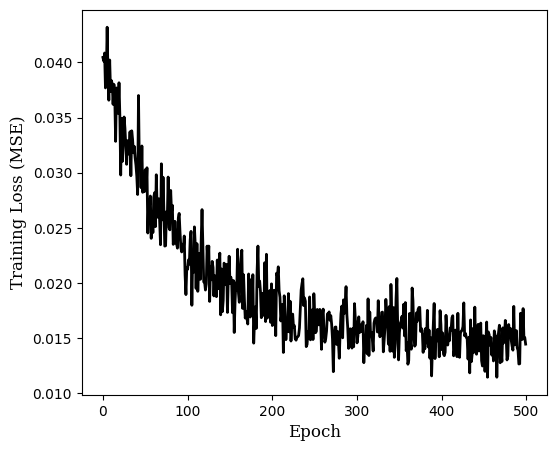

In [ ]:
plt.figure(figsize=(6,5))
csfont = {'fontname':'serif'}

plt.plot(history.history['loss'], lw=2,color='k')
plt.xlabel("Epoch",fontsize=12,**csfont)
plt.ylabel("Training Loss (MSE)",fontsize=12,**csfont)
plt.show()

In [ ]:
data_predict_train = transformer_model.predict(trainX)
data_predict = transformer_model.predict(testX)

1/1 [==============================] - 0s 59ms/step


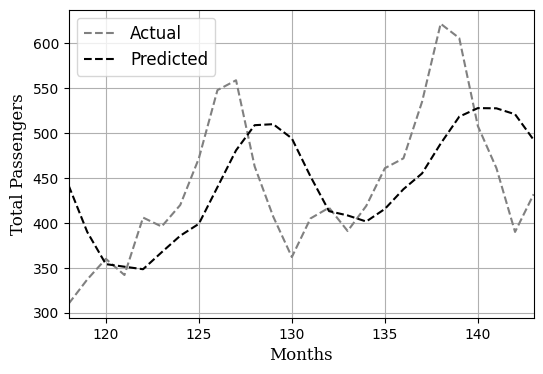

In [ ]:
x = np.arange(144-data_predict.shape[0], 144, 1)
data_predict_plot = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(testY.reshape(-1,1))
plt.figure(figsize=(6,4))


plt.plot(x,dataY_plot,color='Grey',label='Actual',linestyle='--')
plt.plot(x,data_predict_plot,color='Black',label='Predicted',linestyle='--')
plt.xlabel('Months',fontsize=12,**csfont)
plt.ylabel('Total Passengers',fontsize=12,**csfont)
plt.autoscale(axis='x',tight=True)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('predlstm.pdf')
plt.show()

## Introduction

This is the Transformer architecture from
[Attention Is All You Need](https://arxiv.org/abs/1706.03762),
applied to timeseries instead of natural language.

This example requires TensorFlow 2.4 or higher.

## Load the dataset

We are going to use the same dataset and preprocessing as the
[TimeSeries Classification from Scratch](https://keras.io/examples/timeseries/timeseries_classification_from_scratch)
example.

In [ ]:
import numpy as np


def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

## Build the model

Our model processes a tensor of shape `(batch size, sequence length, features)`,
where `sequence length` is the number of time steps and `features` is each input
timeseries.

You can replace your classification RNN layers with this one: the
inputs are fully compatible!

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.

The projection layers are implemented through `keras.layers.Conv1D`.

In [ ]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.

In [ ]:

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


## Train and evaluate

In [ ]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate(x_test, y_test, verbose=1)

## Conclusions

In about 110-120 epochs (25s each on Colab), the model reaches a training
accuracy of ~0.95, validation accuracy of ~84 and a testing
accuracy of ~85, without hyperparameter tuning. And that is for a model
with less than 100k parameters. Of course, parameter count and accuracy could be
improved by a hyperparameter search and a more sophisticated learning rate
schedule, or a different optimizer.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/timeseries_transformer_classification) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/timeseries_transformer_classification).